In [1]:
%matplotlib inline

In [101]:
from io import BytesIO
import base64
from datetime import timedelta

In [3]:
import pandas
pandas.options.display.max_rows = 100

import matplotlib.pyplot as plt

In [4]:
raw_data = pandas.read_json("corona.json")
data = raw_data.drop(columns=["link", "new_reg", "total_reg"]).fillna(0)
regions = data.drop(columns=["new", "total", "total_healthy"]).set_index("date")

In [5]:
regions['total'] = regions.sum(axis=1)

In [6]:
def speed(series):
    return series[0:7].sum() / (series[7:14].sum() or 1)

def last_speed(series):
    return series[7:14].sum() / (series[14:21].sum() or 1)

def weekly(series):
    return series[:7].sum()

def last_weekly(series):
    return series[7:14].sum()

def lastlast_weekly(series):
    return series[14:21].sum()

def figure(series):
    fig, ax = plt.subplots(figsize=(1.0, 0.5));
    series[:21].plot(ax=ax)
    ax.set_ylim(0.0, series[:21].max() * 1.1)
    ax.set_xlabel("")
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([series.index[0], series.index[6], series.index[13]])
    ax.set_yticks([])
    plt.close()
    
    with BytesIO() as buffer:
        fig.savefig(buffer, format='png')
        b64 = base64.b64encode(buffer.getvalue()).decode()
    
    return f'<img src="data:image/png;base64,{b64}">'    

    return fig

In [41]:
data_agg = pandas.DataFrame({
    "This week / Last week": regions.apply(speed),
    "Last week / LastLast week": regions.apply(last_speed),
    "This week": regions.apply(weekly),
    "Last week": regions.apply(last_weekly),
    "LastLast week": regions.apply(lastlast_weekly),

    "21 day": regions.apply(figure),
    "All time": regions.sum()
}).sort_values("This week", ascending=False)

In [42]:
print(regions.index[0])

2020-11-06 00:00:00


,This week / Last week,Last week / LastLast week,This week,Last week,LastLast week,21 day,All time
total,1.11844,1.07183,133464,119330,111333,,1.72656e+06
Москва,1.16121,0.952083,37493,32288,33913,,453993
Санкт-Петербург,1.3437,1.07055,6912,5144,4805,,67271
Московская область,1.12995,1.09315,3965,3509,3210,,90087
Нижегородская область,1.05653,1.17578,2841,2689,2287,,43872
Архангельская область,1.22076,1.27868,2599,2129,1665,,22778
Ростовская область,1.00923,1.02266,2186,2166,2118,,32365
Красноярский край,1.09133,1.16777,2127,1949,1669,,28164
Воронежская область,1.07649,1.16726,2111,1961,1680,,26777
Свердловская область,0.989405,1.12678,1961,1982,1759,,37748

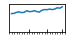
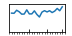
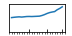
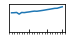
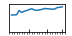
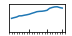
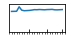
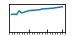
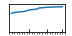
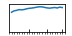
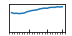
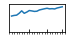
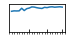
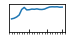
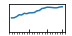
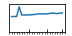
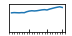
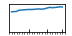
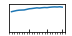
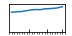
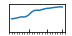
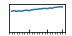
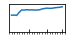
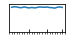
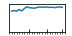
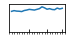
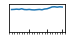
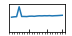
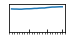
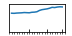
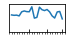
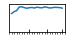
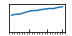
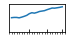
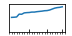
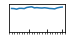
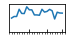
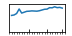
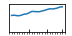
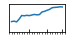
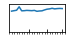
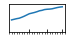
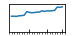
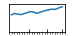
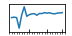
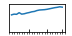
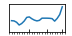
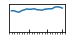
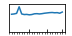
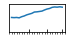
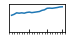
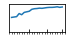
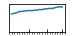
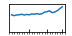
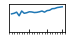
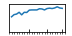
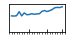
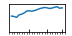
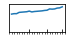
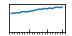
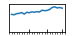
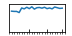
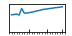
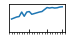
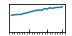
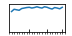
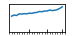
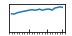
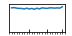
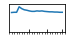
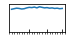
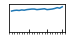
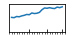
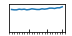
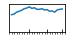
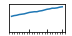
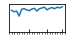
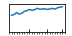
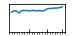
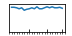
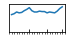
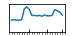
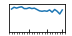
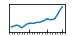
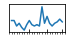
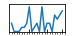

In [43]:
data_agg.style.bar("This week / Last week")

In [52]:
import numpy as np
import plotly.express as px

In [253]:
weeks = regions.sort_index().rolling(7).sum().fillna(0.0).iloc[::-1][::7][::-1]
weeks.index -= timedelta(days=6)

weeks_reldiff = np.exp(np.log(weeks.where(weeks.ne(0.0), 1.0)).diff()).fillna(1.0)

weeks_flat = None

for col in weeks.columns:
    df = pandas.DataFrame({
        'total': weeks[col].cumsum(),
        'cases': weeks[col],
        'reldiff': weeks_reldiff[col]
    }).reset_index()
    df['region'] = col

    if weeks_flat is None:
        weeks_flat = df
    else:
        weeks_flat = weeks_flat.append(df, ignore_index=True, sort=False)

weeks_flat['date'] = weeks_flat.date.apply(lambda x: str(x.date()))
weeks_flat.sort_values(['date', 'region'], inplace=True)

In [254]:
px.scatter(
    weeks_flat,
    x='total',
    y='reldiff',
    #size=np.log10(weeks_flat.cases.where(weeks_flat.cases.ne(0.0), 1.0)),
    hover_name='region',
    animation_frame='date',
    animation_group='region',
    log_x=True,
    range_x=[1, 1e7],
    range_y=[0, 2],
    opacity=0.7
)